In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf
import pandas as pd
import glob
import skimage.io as io

### Сегментация Unet + drone dataset

In [125]:
class DroneDataset():

    def __init__(self):
   
        path_class = "/tf/notebooks/data/dron/class_dict_seg.csv"
        images_path = "/tf/notebooks/data/dron/dataset/semantic_drone_dataset/original_images/*.jpg"
        masks_path  = "/tf/notebooks/data/dron/dataset/semantic_drone_dataset/label_images_semantic/*.png"
        
        self.OUTPUT_SIZE = (256,256)
        self.IMG_SHAPE  = (256,256)
                      
        class_obj = pd.read_csv(path_class)
        self.class_names = class_obj["name"].values
        self.class_num = len(self.class_names)
        self.class_id = class_obj["name"].index
        self.dataset = self.create_dataset(images_path, masks_path)
        
        
    #Функции для загрузки изображения
    def load_image(self, image):
        image = tf.io.read_file(image)
        image = tf.io.decode_jpeg(image)
        image = tf.image.resize(image, self.OUTPUT_SIZE)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image / 255.0
        return image

    def load_mask(self, mask):
        mask = tf.io.read_file(mask)
        mask = tf.io.decode_png(mask)
        #mask = tf.image.grayscale_to_rgb(mask) #Если маски сохранены в GRAY
        #mask = mask[:,:,0:3]
        #mask = tf.image.rgb_to_grayscale(mask)
        mask = tf.image.resize(mask, self.OUTPUT_SIZE)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        
        
         #Создадим маски для каждого класса
        masks = []
        for i in range(self.class_num):
            masks.append(tf.where(tf.equal(mask, float(self.class_id[i])), 1.0, 0.0))
        masks = tf.stack(masks, axis=2)
        masks = tf.reshape(masks, self.OUTPUT_SIZE + (self.class_num,))
    
        return masks
        #mask = mask / self.class_num 
        #return mask

    def load_input_data(self, image, mask):
        image = self.load_image(image)
        mask = self.load_mask(mask)
        return image, mask


    #Аугментация изобажений
    def augmentation(self, image, mask):
        random_crop = tf.random.uniform((), 0.3, 1)
        image = tf.image.central_crop(image, random_crop)
        mask = tf.image.central_crop(mask, random_crop)
        random_flip = tf.random.uniform((), 0, 1)
        if random_flip >= 0.5:
            image = tf.image.flip_left_right(image)
            masks = tf.image.flip_left_right(masks)
        image = tf.image.resize(image, IMG_SHAPE)
        mask  = tf.image.resize(mask, IMG_SHAPE)
        return image, mask
    
    def create_dataset(self, images_path, masks_path):
        
        img_list = sorted(glob.glob(images_path))
        masks_list = sorted(glob.glob(masks_path))
        dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(img_list),
                                tf.data.Dataset.from_tensor_slices(masks_list)))
        dataset = dataset.map(self.load_input_data, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset
    
    def get_train_test_datasets(self, train_size, batch_size, num_epoch):
        #self.dataset = self.dataset.repeat(num_epoch)
        len_dataset = len(self.dataset)
        train_size_items = int(train_size*len_dataset)
        #Делим на train и test
        train_dataset = self.dataset.take(train_size_items).cache()
        test_dataset = self.dataset.skip(train_size_items).take(len_dataset - train_size_items).cache()
        train_dataset = train_dataset.batch(batch_size)
        test_dataset = test_dataset.batch(batch_size) 
        return train_dataset, test_dataset


In [126]:
NUM_EPOCHS = 20
BATCH_SIZE = 8
drone = DroneDataset()
train_dataset, test_dataset= drone.get_train_test_datasets(train_size=0.7, batch_size=BATCH_SIZE, num_epoch= NUM_EPOCHS)

In [127]:
drone.class_names

array(['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water',
       'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door',
       'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree',
       'bald-tree', 'ar-marker', 'obstacle', 'conflicting'], dtype=object)

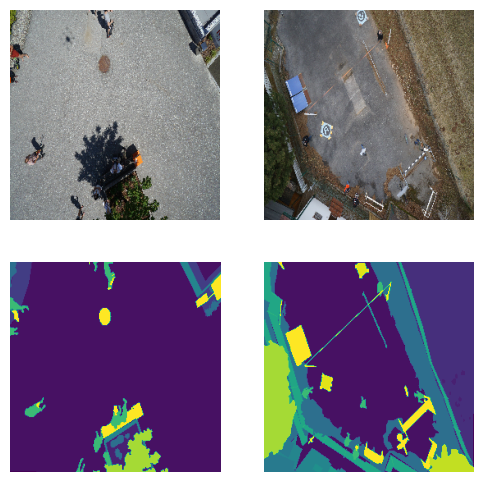

In [120]:
plt.figure(figsize=(6,6))
for im, mask in train_dataset.take(1):
       
    for i in range(2):
        ax= plt.subplot(2, 2, i+1)
        plt.imshow((im[i]*255).numpy().astype("uint8"))

        plt.axis("off")
        
    for j,i in enumerate(range(2,4)):
        ax= plt.subplot(2, 2, i+1)

        plt.imshow((mask[j]*drone.class_num).numpy().astype("uint8"))
        plt.axis("off")   


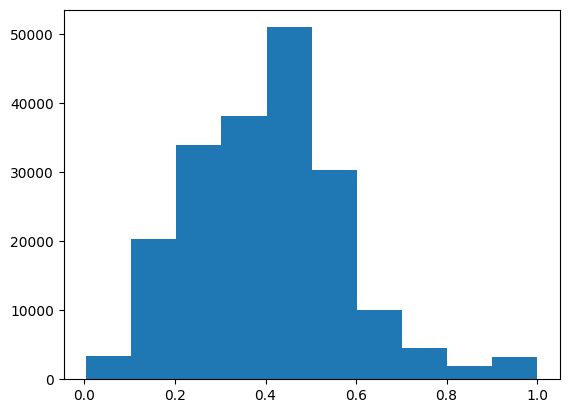

In [40]:
plt.hist(im[i].numpy().ravel())
plt.show()

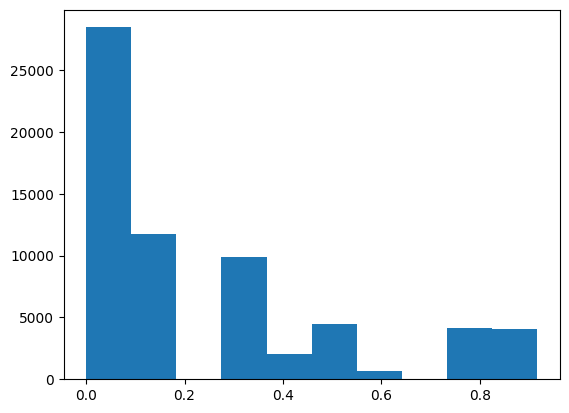

In [121]:
plt.hist(mask[j].numpy().ravel())
plt.show()

In [132]:
classes = drone.class_num
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(classes, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)


In [133]:
model_dice = build_model()

In [134]:
CLASSES = drone.class_num

#Функция для подсчёта DICE коэффициента
def dice_coef(y_pred, y_true):
    y_pred = tf.unstack(y_pred, axis=3)
    y_true = tf.unstack(y_true, axis=3)
    dice_summ = 0

    for i, (a_y_pred, b_y_true) in enumerate(zip(y_pred, y_true)):
        dice_calculate = (2 * tf.math.reduce_sum(a_y_pred * b_y_true) + 1) /\
         (tf.math.reduce_sum(a_y_pred + b_y_true) + 1)
        dice_summ += dice_calculate

    avg_dice = dice_summ/CLASSES
    return avg_dice

#Функция для подсчета DICE loss
def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss

#Binary crossentropy + 0.25 * DICE
def dice_bce_loss(y_pred, y_true):
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss


In [143]:
loss = [dice_bce_loss]
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model_dice.compile(optimizer=opt, loss=loss, metrics=[dice_coef])

In [144]:
NUM_EPOCHS = 1000

Epoch 101/1000
35/35 [==============================] - 9s 133ms/step - loss: 0.3120 - dice_coef: 0.2021 - val_loss: 0.2974 - val_dice_coef: 0.1848
Epoch 102/1000
35/35 [==============================] - 4s 122ms/step - loss: 0.2859 - dice_coef: 0.2255 - val_loss: 0.2812 - val_dice_coef: 0.2129
Epoch 103/1000
35/35 [==============================] - 4s 122ms/step - loss: 0.2821 - dice_coef: 0.2352 - val_loss: 0.2795 - val_dice_coef: 0.2156
Epoch 104/1000
35/35 [==============================] - 4s 123ms/step - loss: 0.2825 - dice_coef: 0.2340 - val_loss: 0.2798 - val_dice_coef: 0.2164
Epoch 105/1000
35/35 [==============================] - 4s 122ms/step - loss: 0.2815 - dice_coef: 0.2361 - val_loss: 0.2815 - val_dice_coef: 0.2137
Epoch 106/1000
35/35 [==============================] - 4s 122ms/step - loss: 0.2815 - dice_coef: 0.2373 - val_loss: 0.2810 - val_dice_coef: 0.2155
Epoch 107/1000
35/35 [==============================] - 4s 122ms/step - loss: 0.2803 - dice_coef: 0.2390 - val_l

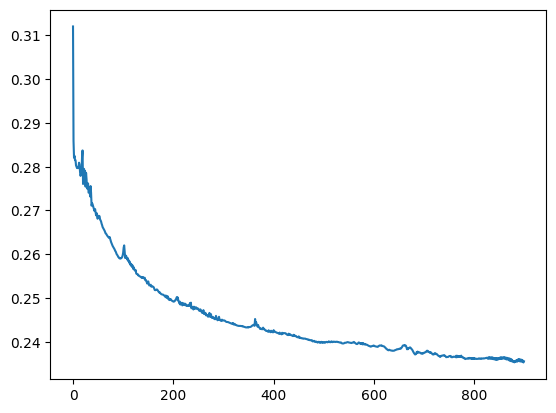

In [145]:
model_dice_history = model_dice.fit(train_dataset,
              validation_data=test_dataset,
              epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, initial_epoch=100)

plt.plot(model_dice_history.history['loss'])

In [146]:
NUM_EPOCHS = 10000

Epoch 1001/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2353 - dice_coef: 0.3443 - val_loss: 0.2394 - val_dice_coef: 0.3101
Epoch 1002/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2354 - dice_coef: 0.3442 - val_loss: 0.2397 - val_dice_coef: 0.3097
Epoch 1003/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2351 - dice_coef: 0.3445 - val_loss: 0.2392 - val_dice_coef: 0.3104
Epoch 1004/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2352 - dice_coef: 0.3444 - val_loss: 0.2394 - val_dice_coef: 0.3101
Epoch 1005/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2350 - dice_coef: 0.3446 - val_loss: 0.2392 - val_dice_coef: 0.3104
Epoch 1006/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2353 - dice_coef: 0.3443 - val_loss: 0.2395 - val_dice_coef: 0.3098
Epoch 1007/10000
35/35 [==============================] - 4s 122ms/step - loss: 0.2350 - dice_coef: 

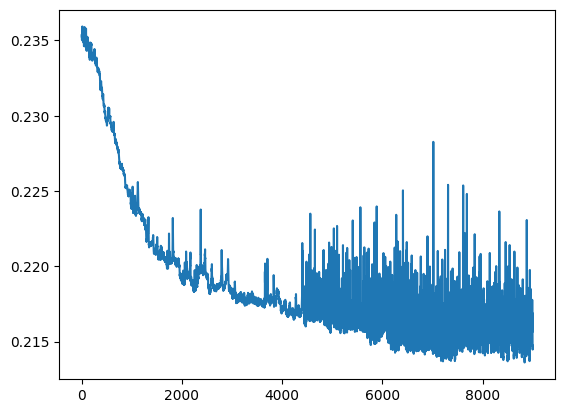

In [147]:
model_dice_history = model_dice.fit(train_dataset,
              validation_data=test_dataset,
              epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, initial_epoch=1000)

plt.plot(model_dice_history.history['loss'])

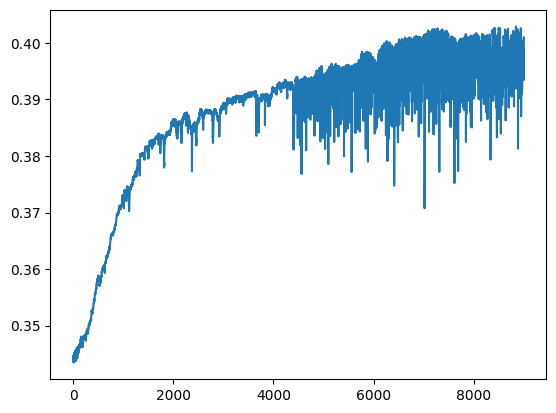

In [148]:
plt.plot(model_dice_history.history['dice_coef'])

In [149]:
out = model_dice.predict(test_dataset)


15/15 [==============================] - 1s 32ms/step


In [166]:
drone.class_id.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [180]:
def concat_mask(mask):
    labele = np.zeros((mask.shape[0], mask.shape[1]))
    for channel in drone.class_id:
        labele += (mask[:,:,channel].numpy())*channel
    return labele

In [185]:
def concat_out(out):
    labele = np.zeros((out.shape[0], out.shape[1]))
    for channel in drone.class_id:
        labele += (out[:,:,channel])*channel
    return labele

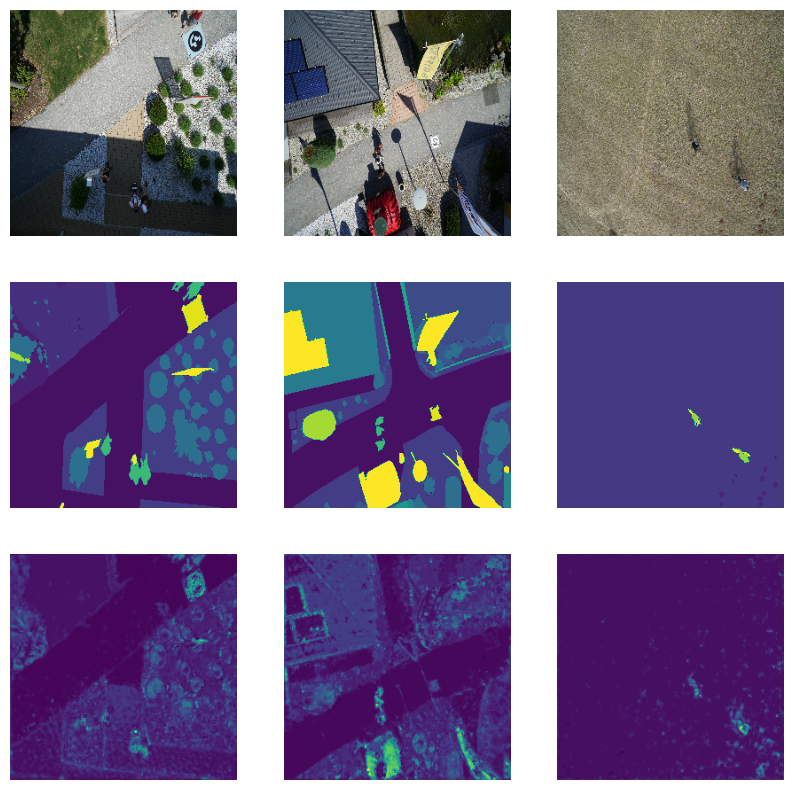

In [190]:
plt.figure(figsize=(10,10))
shift = 3
for im, mask in test_dataset.skip(shift).take(1):
       
    for i in range(3):
        ax= plt.subplot(3, 3, i+1)
        plt.imshow((im[i]*255).numpy().astype("uint8"))

        plt.axis("off")
        
    for j,i in enumerate(range(3,6)):
        ax= plt.subplot(3, 3, i+1)

        plt.imshow((concat_mask(mask[j])).astype("uint8"))
        plt.axis("off")  
        
    for j,i in enumerate(range(6,9)):
        ax= plt.subplot(3, 3, i+1)

        plt.imshow((concat_out(out[j+shift*BATCH_SIZE])).astype("uint8"))
        plt.axis("off")   